In [1]:
# morans I

In [2]:
import pandas as pd
import pickle
import pysal as ps
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy
import xlrd
from ukpostcodeutils import validation
from scipy.special import ndtri
from scipy.stats import chi2
from math import sqrt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from tqdm import tqdm
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm

%matplotlib inline

/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
infile = open('df','rb')
df = pickle.load(infile)
infile.close()

infile = open('dcut','rb')
dcut = pickle.load(infile)
infile.close()

infile = open('areacut','rb')
areacut = pickle.load(infile)
infile.close()

infile = open('rural_nsyc_vs_syc','rb')
rural_nsyc_vs_syc = pickle.load(infile)
infile.close()

infile = open('urban_nsyc_vs_syc','rb')
urban_nsyc_vs_syc = pickle.load(infile)
infile.close()

infile = open('rural_coastal_syc_vs_rural_coastal_nsyc','rb')
rural_coastal_syc_vs_rural_coastal_nsyc = pickle.load(infile)
infile.close()

infile = open('urban_coastal_syc_vs_rural_coastal_nsyc','rb')
urban_coastal_syc_vs_rural_coastal_nsyc = pickle.load(infile)
infile.close()

l = dict(zip(['cr', 'ar', 'ds', 'smr'], [i for i in range(0,4)]))
l2 = dict(zip(['cr2', 'ar2', 'ds2', 'smr2', 'da2'], [i for i in range(0,5)]))

# dcut is dockyard cuts
# areacut is area cuts
# cr = crude rate, ar = age-adjusted rate, ds = directly standardised rate, smr= indirect smr
# da = dockyard analysis

In [4]:
def meso_moran_ward(df):
    """
    Calculates Moran's I for mesothelioma SMR at ward level for 2002-2015
    """
    # http://geoportal.statistics.gov.uk/datasets/wards-december-2016-super-generalised-clipped-boundaries-in-great-britain
    # ogr2ogr -f GeoJSON wards.json Wards_December_2016_Super_Generalised_Clipped_Boundaries_in_Great_Britain.kml
    wards = gpd.read_file('wards.json') 
    
    # rename for merge adding geo data
    wards.rename(index=str, columns={"wd16cd": "WD16CD"}, inplace=True)

    # calculate SMR for all years and geo data
    df = GeoDataFrame(pd.merge(df, wards, on='WD16CD'))

    # make a geodataframe with UK projection
    crs = {'init': 'epsg:27700'}
    df = GeoDataFrame(df, crs=crs)

    # throw away islands
    islands = list(df.loc[[ 4803, 5476, 5665]]['WD16CD'].values)
    df = df[~df['WD16CD'].isin(islands)]
    
    # queens continguity weights and row-normalisation
    w = ps.weights.Queen.from_dataframe(df)
    w.transform = 'r' 
    
    # calculate Moran's I
    mi = ps.Moran(df['directly_standardised_rate_per_1000'], w)

     # print Moran's I
    print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm]))
    
    mi_ll = mi.I - mi.seI_norm / sqrt(len(df))
    mi_ul = mi.I + mi.seI_norm / sqrt(len(df))
    
    print("\n 95% CI for Moran's I: {}-{}".format(mi_ll, mi_ul))

In [5]:
meso_moran_ward(areacut['all-years'][l['ds']]['WD16CD'])

Morans I     0.194134
Z-Score     28.782504
P-Value      0.000000
dtype: float64

 95% CI for Moran's I: 0.19406006707737322-0.19420853293175772


In [6]:
meso_moran_ward(areacut['men-only pre-2009'][l['ds']]['WD16CD'])

Morans I     0.127666
Z-Score     18.934045
P-Value      0.000000
dtype: float64

 95% CI for Moran's I: 0.12759207525211294-0.12774054110649743


In [7]:
meso_moran_ward(areacut['men-only post-2009'][l['ds']]['WD16CD'])

Morans I     0.079875
Z-Score     11.852910
P-Value      0.000000
dtype: float64

 95% CI for Moran's I: 0.07980096245775228-0.07994942831213675


In [8]:
def meso_moran_lad(df):
    """
    Calculates Moran's I for mesothelioma SMR at ward level for 2002-2015
    """
    # http://geoportal.statistics.gov.uk/datasets/wards-december-2016-super-generalised-clipped-boundaries-in-great-britain
    # ogr2ogr -f GeoJSON wards.json Wards_December_2016_Super_Generalised_Clipped_Boundaries_in_Great_Britain.kml
    lads = gpd.read_file('lads.json') 
    
    # rename for merge adding geo data
    lads.rename(index=str, columns={"lad16cd": "LAD16CD"}, inplace=True)

    # calculate SMR for all years and geo data
    df = GeoDataFrame(pd.merge(df, lads, on='LAD16CD'))

    # make a geodataframe with UK projection
    crs = {'init': 'epsg:27700'}
    df = GeoDataFrame(df, crs=crs)

    # throw away islands
    islands = list(df.loc[[45, 51, 326]]['LAD16CD'].values)
    df = df[~df['LAD16CD'].isin(islands)]
    
    # queens continguity weights and row-normalisation
    w = ps.weights.Queen.from_dataframe(df)
    w.transform = 'r' 
    
    # calculate Moran's I
    mi = ps.Moran(df['directly_standardised_rate_per_1000'], w)

    # print Moran's I
    print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_sim]))
    
    mi_ll = mi.I - (mi.seI_norm / sqrt(len(df)))
    mi_ul = mi.I + (mi.seI_norm / sqrt(len(df)))
    
    print("\n 95% CI for Moran's I: {}-{}".format(mi_ll, mi_ul))
    
    print("width = {}".format(mi_ul-mi_ll))
    
def meso_moran_lad2(df):
    """
    Calculates Moran's I for mesothelioma SMR at ward level for 2002-2015
    """
    # http://geoportal.statistics.gov.uk/datasets/wards-december-2016-super-generalised-clipped-boundaries-in-great-britain
    # ogr2ogr -f GeoJSON wards.json Wards_December_2016_Super_Generalised_Clipped_Boundaries_in_Great_Britain.kml
    lads = gpd.read_file('lads.json') 
    
    # rename for merge adding geo data
    lads.rename(index=str, columns={"lad16cd": "LAD16CD"}, inplace=True)

    # calculate SMR for all years and geo data
    df = GeoDataFrame(pd.merge(df, lads, on='LAD16CD'))

    # make a geodataframe with UK projection
    crs = {'init': 'epsg:27700'}
    df = GeoDataFrame(df, crs=crs)

    # throw away islands
    islands = list(df.loc[[45, 51, 326]]['LAD16CD'].values)
    df = df[~df['LAD16CD'].isin(islands)]
    
    # queens continguity weights and row-normalisation
    w = ps.weights.Queen.from_dataframe(df)
    w.transform = 'r' 
    
    # calculate Moran's I
    mi = ps.Moran(df['crude_rate_per_1000'], w)

    # print Moran's I
    print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_sim]))
    
    mi_ll = mi.I - (mi.seI_norm / sqrt(len(df)))
    mi_ul = mi.I + (mi.seI_norm / sqrt(len(df)))
    
    print("\n 95% CI for Moran's I: {}-{}".format(mi_ll, mi_ul))
    
    print("width = {}".format(mi_ul-mi_ll))

def meso_moran_lad3(df):
    """
    Calculates Moran's I for mesothelioma SMR at ward level for 2002-2015
    """
    # http://geoportal.statistics.gov.uk/datasets/wards-december-2016-super-generalised-clipped-boundaries-in-great-britain
    # ogr2ogr -f GeoJSON wards.json Wards_December_2016_Super_Generalised_Clipped_Boundaries_in_Great_Britain.kml
    lads = gpd.read_file('lads.json') 
    
    # rename for merge adding geo data
    lads.rename(index=str, columns={"lad16cd": "LAD16CD"}, inplace=True)

    # calculate SMR for all years and geo data
    df = GeoDataFrame(pd.merge(df, lads, on='LAD16CD'))

    # make a geodataframe with UK projection
    crs = {'init': 'epsg:27700'}
    df = GeoDataFrame(df, crs=crs)

    # throw away islands
    islands = list(df.loc[[45, 51, 326]]['LAD16CD'].values)
    df = df[~df['LAD16CD'].isin(islands)]
    
    # queens continguity weights and row-normalisation
    w = ps.weights.Queen.from_dataframe(df)
    w.transform = 'r' 
    
    # calculate Moran's I
    mi = ps.Moran(df['smr'], w)

    # print Moran's I
    print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_sim]))
    
    mi_ll = mi.I - (mi.seI_norm / sqrt(len(df)))
    mi_ul = mi.I + (mi.seI_norm / sqrt(len(df)))
    
    print("\n 95% CI for Moran's I: {}-{}".format(mi_ll, mi_ul))
    
    print("width = {}".format(mi_ul-mi_ll))    
    



In [9]:
areacut['all-years'][l['smr']]['LAD16CD']

,LAD16CD,observed,expected,smr,lower_o,upper_o,lower_ci,upper_ci
0,E06000001,101.0,49.505575,204.017425,82.264284,122.725296,166.171757,247.901969
1,E06000002,87.0,67.169409,129.523248,69.681385,107.315375,103.739763,159.768229
2,E06000003,114.0,81.568076,139.760560,94.034196,136.949918,115.283088,167.896467
3,E06000004,164.0,95.397135,171.912920,139.858949,191.110521,146.607076,200.331511
4,E06000005,75.0,57.589466,130.232150,58.990019,94.014401,102.431961,163.249301
5,E06000006,75.0,59.053820,127.002792,58.990019,94.014401,99.891962,159.201218
6,E06000007,103.0,100.509162,102.478220,84.070085,124.918588,83.644201,124.285773
7,E06000008,51.0,61.742767,82.600769,37.970021,67.056965,61.497116,108.606998
8,E06000009,87.0,86.260857,100.856869,69.681385,107.315375,80.779843,124.407962
9,E06000010,114.0,117.134832,97.323740,94.034196,136.949918,80.278594,116.916476


In [10]:
meso_moran_lad(areacut['all-years'][l['ds']]['LAD16CD'])

Morans I     0.378089
Z-Score     10.723033
P-Value      0.001000
dtype: float64

 95% CI for Moran's I: 0.376176138310824-0.38000194698974293
width = 0.003825808678918907


In [11]:
meso_moran_lad(areacut['men-only'][l['ds']]['LAD16CD'])

Morans I     0.362511
Z-Score     10.284605
P-Value      0.001000
dtype: float64

 95% CI for Moran's I: 0.3605985123310371-0.36442432100995603
width = 0.003825808678918907


In [12]:
meso_moran_lad(areacut['men-only pre-2009'][l['ds']]['LAD16CD'])

Morans I    0.317489
Z-Score     9.017471
P-Value     0.001000
dtype: float64

 95% CI for Moran's I: 0.3155764797316574-0.31940228841057633
width = 0.003825808678918907


In [13]:
meso_moran_lad(areacut['men-only post-2009'][l['ds']]['LAD16CD'])

Morans I    0.312029
Z-Score     8.863783
P-Value     0.001000
dtype: float64

 95% CI for Moran's I: 0.31011583894759015-0.31394164762650906
width = 0.003825808678918907


In [14]:
meso_moran_lad(areacut['men-only'][l['ds']]['LAD16CD'])

Morans I     0.362511
Z-Score     10.284605
P-Value      0.001000
dtype: float64

 95% CI for Moran's I: 0.3605985123310371-0.36442432100995603
width = 0.003825808678918907


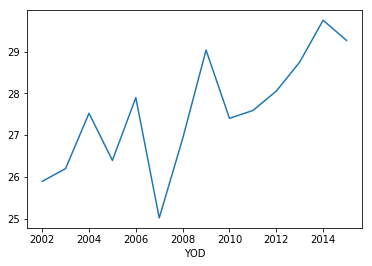

In [15]:
df[df.SEX == 1].groupby('YOD').disttodock.median().plot()